In [3]:
# https://github.com/saqib1707/RL-PPO-PyTorch/blob/main/src/ppo.py
# https://github.com/vwxyzjn/ppo-implementation-details/blob/main/ppo_atari.py
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 
from torch.distributions import Categorical

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import pandas as pd
import utils

TS = 48
MPATH = '__pycache__/ppo_net.pt'
DO_TRAIN = False

# samples = list(range(201, 211)) #[201, 202, 203]
samples = [221, 243, 232, 202, 204, 214, 205, 239, 248, 273, 282, 289]
data_train, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)

State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [5]:
class PPO(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PPO, self).__init__()
        self.num_actions = n_actions
        DIM1 = 256
        DIM2 = 128
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(n_observations, DIM1),
            nn.Tanh(),
            nn.Linear(DIM1, DIM2),
            nn.Tanh()
        ).to(device)        
                
        self.actor = nn.Sequential(
                nn.Linear(DIM2, n_actions),
                nn.Softmax(dim=-1)
            ).to(device)

        self.critic = nn.Linear(DIM2, 1).to(device)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        features = self.feature_extractor(x)
        policy_dist = self.actor(features)
        value = self.critic(features)
        
        return value, policy_dist

    def evaluate_actions(self, x, actions):
        values, logits = self.forward(x)

        dist = Categorical(logits) #logits.detach().numpy()
        entropy = dist.entropy()
        # entropy = -np.sum(dist * np.log(dist + 1e-16))

        # log_prob = torch.log(logits.squeeze(0)[action])
        log_prob = dist.log_prob(actions.squeeze(-1).long())    
        
        return values.squeeze(), log_prob, entropy

In [6]:
NUM_EPOCH = 10
MINI_BATCH_SIZE = TS//4
EPS_CLIP = 0.2
GAMMA = 0.9
MAX_GDNORM = 0.1

n_observaons = 7
print(n_observaons)
n_actions = 2
ppo_net = PPO(n_observaons, n_actions).to(device)
optimizer = optim.Adam(ppo_net.parameters(), lr=1e-5)

7


In [7]:
if DO_TRAIN == True:
    all_lengths = []
    average_lengths = []
    all_rewards = []
    all_sc_ss = []

    loop = 10    
    num_episodes = len(data_train)

    for l in range(loop):
        for i_episode in range(num_episodes):
            capacities = utils.cal_stds(data_train[i_episode%len(data_train)])
            for c in capacities:
                env = utils.ENV_BATT(data_train[i_episode%len(data_train)], max(0, c))
                state = env.reset()    

                states = []
                actions = []
                log_probs = []
                values = []
                rewards = []
                
                total_export = 0.0
                total_import = 0.0
                total_pv = 0.0
                total_ld = 0.0
                    
                for i in range(env.data_env.shape[0]):
                    with torch.no_grad():
                        value, policy_dist = ppo_net.forward(state)
                        value = value.detach().numpy()[0]
                        dist = policy_dist.detach().numpy()
                        action = np.random.choice(n_actions, p=np.squeeze(dist))
                        
                        log_prob = torch.log(policy_dist.squeeze(0)[action])
                        new_state, reward, done = env.step(action)

                        states.append(state)
                        actions.append(action)
                        rewards.append(reward.squeeze(0))
                        values.append(value)
                        log_probs.append(log_prob)

                        state = new_state

                        total_export += state.numpy()[5] if state.numpy()[5] < 0 else 0
                        total_import += state.numpy()[5] if state.numpy()[5] > 0 else 0
                        total_pv += state.numpy()[0]
                        total_ld += state.numpy()[1]

                    # if done:
                    if (i + 1) % TS == 0:
                        Qval, _ = ppo_net.forward(new_state)
                        Qval = Qval.detach().numpy()[0]
                        all_rewards.append(np.sum(rewards))
                        all_lengths.append(i)
                        average_lengths.append(np.mean(all_lengths[-10:]))
                        # print("episode: {}, reward: {}, total length: {}, average length: {} \n".format(i_episode, np.sum(rewards), i, average_lengths[-1]))

                        # compute Q values
                        Qvals = np.zeros_like(values)
                        for t in reversed(range(len(rewards))):
                            Qval = rewards[t] + GAMMA * Qval
                            Qvals[t] = Qval
                            
                        advantages =  Qvals - values

                        #update actor critic
                        states = torch.stack(states)
                        actions = torch.FloatTensor(actions)
                        values = torch.FloatTensor(values)
                        Qvals = torch.FloatTensor(Qvals)
                        log_probs = torch.stack(log_probs)
                        advantages = torch.FloatTensor(advantages)

                        for _ in range(NUM_EPOCH):
                            indices = np.random.permutation(len(states))

                            for start_idx in range(0, len(states), MINI_BATCH_SIZE):
                                end_idx = start_idx + MINI_BATCH_SIZE
                                batch_indices = indices[start_idx:end_idx]

                                batch_states = states[batch_indices]
                                batch_actions = actions[batch_indices]
                                batch_log_probs = log_probs[batch_indices]
                                batch_advantages = advantages[batch_indices]
                                batch_qvals = Qvals[batch_indices]

                                # evaluate old actions and values
                                state_values, logprobs, dist_entropy = ppo_net.evaluate_actions(batch_states, batch_actions.long())

                                ratios = torch.exp(logprobs - batch_log_probs.squeeze(-1))
                                surr1 = ratios * batch_advantages
                                surr2 = torch.clamp(ratios, 1 - EPS_CLIP, 1 + EPS_CLIP) * batch_advantages

                                actor_loss = -torch.min(surr1, surr2).mean()
                                critic_loss = 0.5 * nn.MSELoss()(state_values.squeeze(), batch_qvals)
                                loss = actor_loss + critic_loss - 0.01 * dist_entropy.mean()
                                print('loss', i_episode, loss.item())

                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()
                                
                        states = []
                        actions = []
                        log_probs = []
                        values = []
                        rewards = []

                sc = (total_pv + total_export)/total_pv
                ss = (total_ld - total_import)/total_ld
                all_sc_ss.append([sc, ss])
                print(l, i_episode, 'sc and ss', sc, ss)
                
        torch.save(ppo_net.state_dict(), MPATH)


In [8]:
if DO_TRAIN == True:
    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.figure(figsize=(16, 4))
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

    plt.plot(np.array(all_sc_ss)[:, 0])
    plt.plot(np.array(all_sc_ss)[:, 1])
    plt.show()

In [102]:
data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [75], TS)
data_test = data_test[0]
stds = utils.cal_stds(data_test)
print('SD', stds)
WPV = 0.80 # Optimize PV capacity
data_test['GG'] = data_test['GG']*WPV
stds2 = utils.cal_stds(data_test)
print('Modified SD', stds2)

SD (25, 33, 41, 58)
Modified SD (14, 21, 28, 41)


In [127]:
capacity = 13#stds[0]
env = utils.ENV_BATT(data_test, max(0, capacity))
state = env.reset()    
state = state.clone().detach().unsqueeze(0)

ppo_net.load_state_dict(torch.load(MPATH, weights_only=True))

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]):
        _, logits = ppo_net.forward(state)
        # prob = F.softmax(logits, dim=1).data
        action = torch.argmax(logits, dim=1).numpy()[0]
        # print(logits, action)
        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


                         PV     LD      BT   AC     GD        RD
2012-07-01 00:30:00  0.0000  1.098  1.3000  0.0  1.098  0.000000
2012-07-01 01:00:00  0.0000  1.431  1.3000  0.0  1.431  0.000000
2012-07-01 01:30:00  0.0000  0.195  1.3000  0.0  0.195  0.000000
2012-07-01 02:00:00  0.0000  0.145  1.3000  0.0  0.145  0.000000
2012-07-01 02:30:00  0.0000  0.453  1.3000  0.0  0.453  0.000000
...                     ...    ...     ...  ...    ...       ...
2012-07-05 22:30:00  0.0000  1.486  5.8320 -1.0  0.000  0.898865
2012-07-05 23:00:00  0.0048  1.226  4.6108 -1.0  0.000  0.897650
2012-07-05 23:30:00  0.0000  0.463  4.1478 -1.0  0.000  0.891736
2012-07-06 00:00:00  0.0000  0.215  3.9328 -1.0  0.000  0.889783
2012-07-06 00:30:00  0.0000  0.803  3.1298 -1.0  0.000  0.889541

[241 rows x 6 columns]


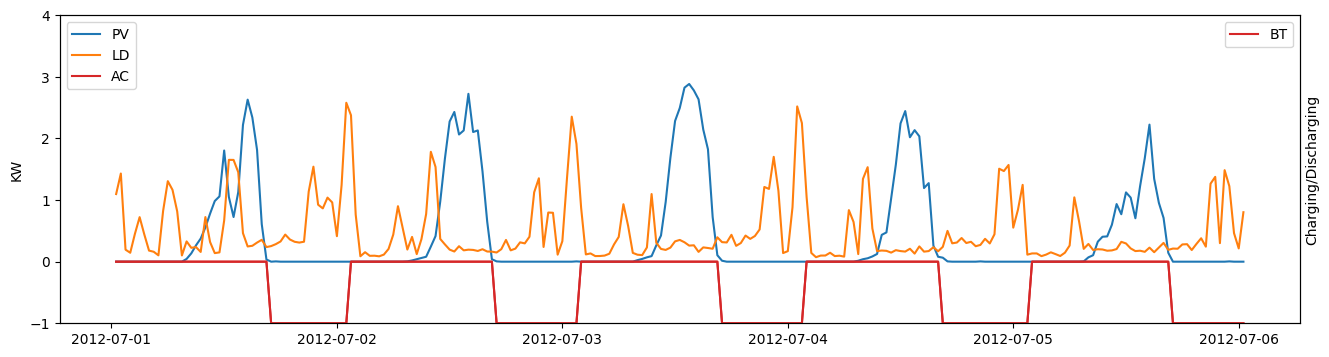

In [128]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

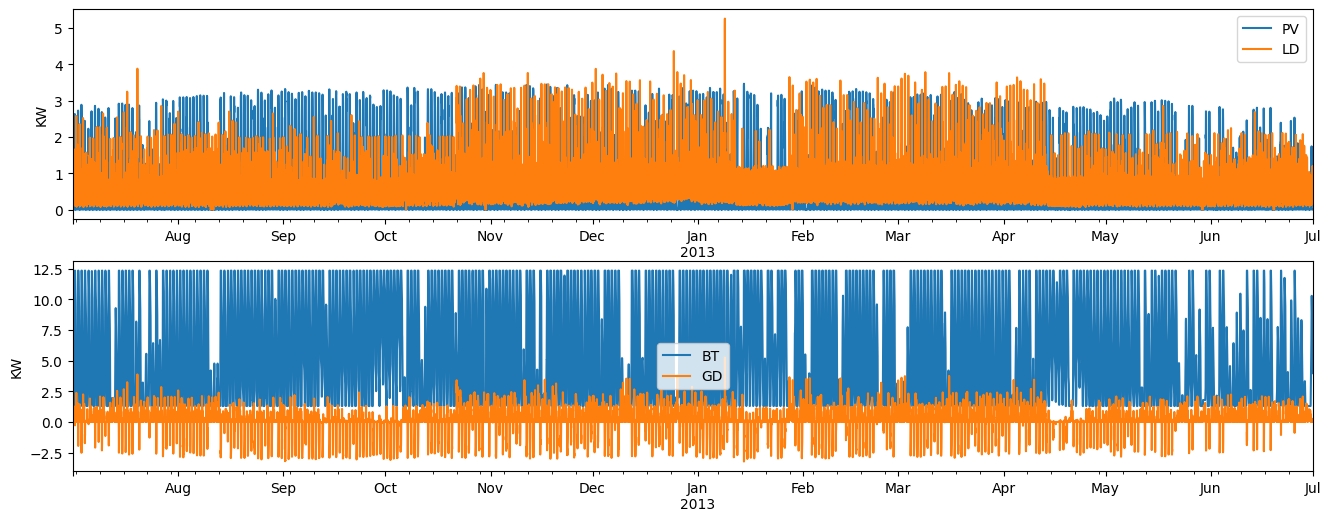

In [129]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])
# df_dis[['AC']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [130]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)

9648.691199692897 KW
9600.995001181494 KW
3695.7117990123807
-3740.7253994132916
SC : 0.6123074806734043
SS : 0.6150699173827725


[    0.             0.             0.         ... -3740.72539941
 -3740.72539941 -3740.72539941]


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_17713/1945581510.py:8: RuntimeWarning: invalid value encountered in divide
  ss =  (c_pv + c_ex) / c_pv


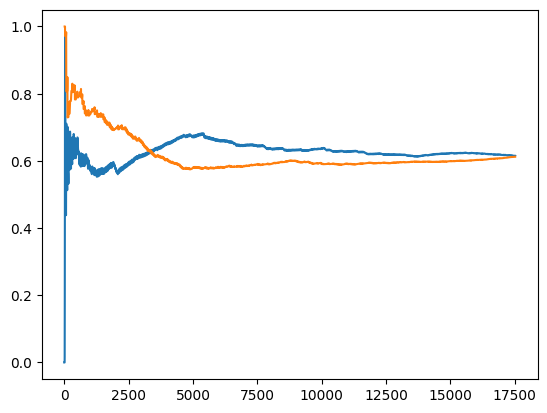

In [131]:
c_pv = np.cumsum(df_out['PV'].values)
c_ld = np.cumsum(df_out['LD'].values)
c_ex = df_out['GD'].values
c_ex[c_ex > 0] = 0
c_ex = np.cumsum(c_ex)

sc =  (c_pv + c_ex) / c_ld
ss =  (c_pv + c_ex) / c_pv

sc[np.isnan(sc)] = 0
print(c_ex)
# plt.plot(c_pv)
# plt.plot(c_ld)
# plt.plot(c_ex)
plt.plot(sc)
plt.plot(ss)

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>